In [15]:
from src.data import load_karate_club, load_cora_dataset
from src.experiments import show_karate_gt_vs_prediction, report_metrics, draw_dot_plot, rearrange_tau

from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from sklearn.cluster import KMeans

import networkx as nx
import numpy as np
import os
import time
from matplotlib import pyplot as plt

In [16]:
%reload_ext autoreload
%autoreload 2

# Spectral clustering method

In [4]:
def spectral_clustering(G, k):

    nb_nodes = G.number_of_nodes()
    adjacency_matrix = nx.adjacency_matrix(G)
    degree_sequence = np.array([G.degree(node) for node in G.nodes()])
    D_inv = diags(1/degree_sequence)
    laplacian =  eye(nb_nodes) - D_inv @ adjacency_matrix

    eigenvalues, eigenvectors = eigs(laplacian, k=k, which = "SM")
    U = np.real(eigenvectors)
    kmeans = KMeans(n_clusters = k).fit(U)
    labels = list(kmeans.labels_)

    return dict(zip(G.nodes(), labels))

# Zachary's Karate Club dataset

In [5]:
X, y = load_karate_club()
G = nx.from_numpy_array(X)
Q = 2

Number of nodes: 34
Number of edges: 78


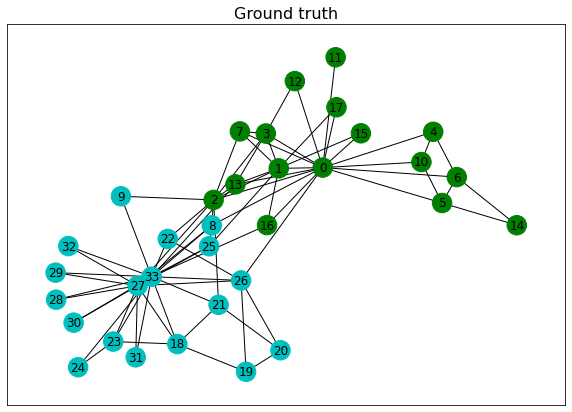

In [7]:
pos = nx.spring_layout(G, seed=42)
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10, 7))
color_list = ["g", "c", "r"]
node_colors = [color_list[i] for i in y]
nx.draw_networkx(G, node_color=node_colors, pos=pos, node_size=380)
plt.title("Ground truth", fontsize=16)
plt.savefig("images/karate_club_gt")

In [8]:
pred_clusters = spectral_clustering(G, Q).values()
# one hot encoding of predicted clusters
tau_pred = np.zeros((G.number_of_nodes(), Q))
for i, cluster in enumerate(pred_clusters):
    tau_pred[i, cluster] = 1

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


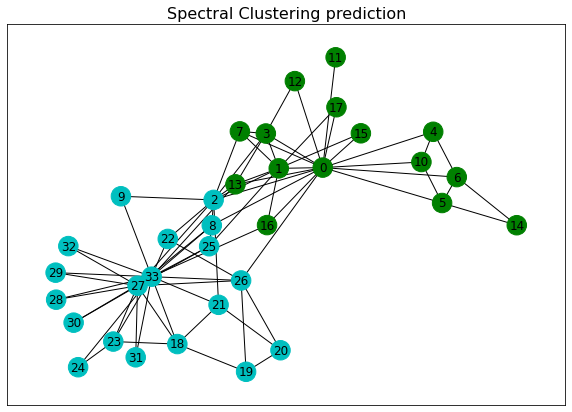

In [9]:
pos = nx.spring_layout(G, seed=42)
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10, 7))
color_list = ["g", "c", "r"]
node_colors = [color_list[i] for i in np.argmax(tau_pred, axis=1)]
nx.draw_networkx(G, node_color=node_colors, pos=pos, node_size=380)
plt.title("Spectral Clustering prediction", fontsize=16)
plt.savefig("images/karate_club_spectral")

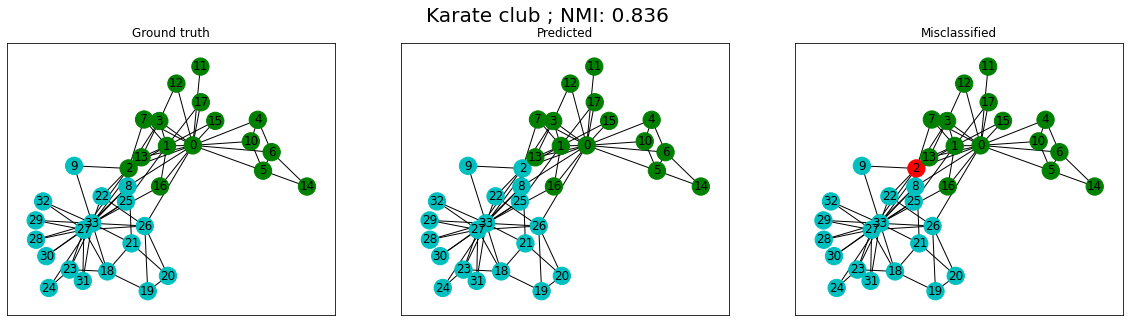

In [10]:
show_karate_gt_vs_prediction(G, tau_pred, y)

In [26]:
report_metrics(X, tau_pred, y, Q)

NMI: 0.836
Rand index: 0.941
Gt Modularity: 0.371
Pred Modularity: 0.360
Graph clustering coefficient: 0.2556818181818182
Per class gt clustering coefficients: [0.41899441340782123, 0.25961538461538464]
Per class pred clustering coefficients: [0.34782608695652173, 0.23949579831932774]


# Cora dataset

In [17]:
X, y = load_cora_dataset()
G = nx.from_numpy_array(X)
Q = 7

Number of nodes: 2708
Number of edges: 5278


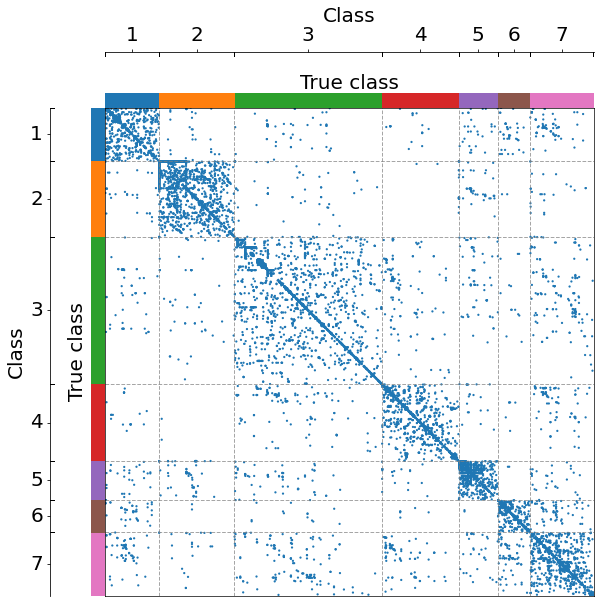

In [18]:
# Plot ground truth clustering
draw_dot_plot(X, y + 1, y + 1)

In [19]:
# Run EM algorithm
t0 = time.time()
pred_clusters = spectral_clustering(G, Q).values()
print("running time:", time.time() - t0)
# one hot encoding of predicted clusters
tau_pred = np.zeros((G.number_of_nodes(), Q))
for i, cluster in enumerate(pred_clusters):
    tau_pred[i, cluster] = 1

running time: 0.6891708374023438


c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


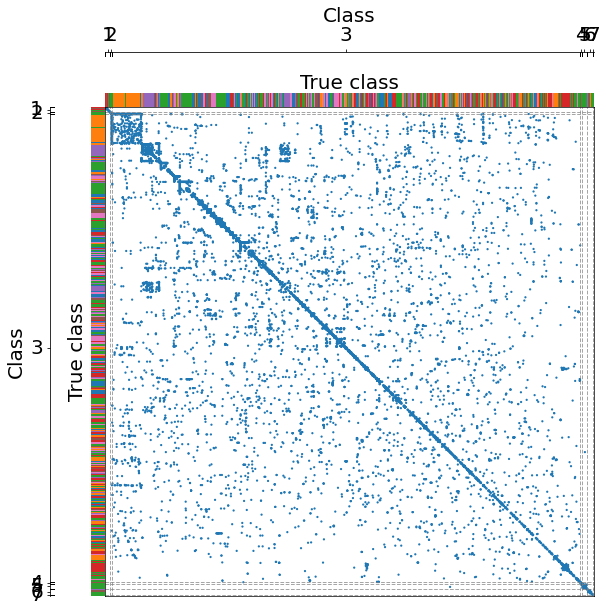

In [20]:
# Plot result
rearranged_tau_pred = rearrange_tau(tau_pred, y, Q=Q)
classification = rearranged_tau_pred.argmax(axis=1) + 1
draw_dot_plot(X, classification, y + 1, save_as="cora_spetral")

In [34]:
report_metrics(X, rearranged_tau_pred, y, Q)

NMI: 0.016
Rand index: 0.225
Gt Modularity: 0.640
Pred Modularity: 0.026
Graph clustering coefficient: 0.09349725626661058
Per class gt clustering coefficients: [0.18568665377176016, 0.05947263745428883, 0.12287887653598596, 0.2283628779979145, 0.10072090628218332, 0.22003577817531306, 0.1627731725697061]
Per class pred clustering coefficients: [0.6, 0.7058823529411765, 0.0931060214683428, 0.0, 0, 0, 0]
